# 2023-09-05 · Ceil spikes 

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.4 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … 

[ Info: Precompiling Nto1AdEx [368485ca-63bc-4029-854f-349d2205662c]


✔ (2.4 s)
using StatsBase … ✔ (0.3 s)


In [2]:
N = 6500
duration = 10minutes

@time sim = Nto1AdEx.sim(N, duration, record_all=true, ceil_spikes=false);

  4.771514 seconds (8.03 M allocations: 1.869 GiB, 19.80% gc time, 31.47% compilation time)


In [4]:
@time sim_ceil = Nto1AdEx.sim(N, duration, ceil_spikes=true);

  2.675778 seconds (317.49 k allocations: 932.533 MiB, 5.47% gc time, 7.76% compilation time: 91% of which was recompilation)


In [5]:
include("lib/plot.jl")

import PythonCall … ✔ (2.8 s)
import PythonPlot … ✔ (7.1 s)
using Sciplotlib … ✔ (0.7 s)
using PhDPlots … ✔


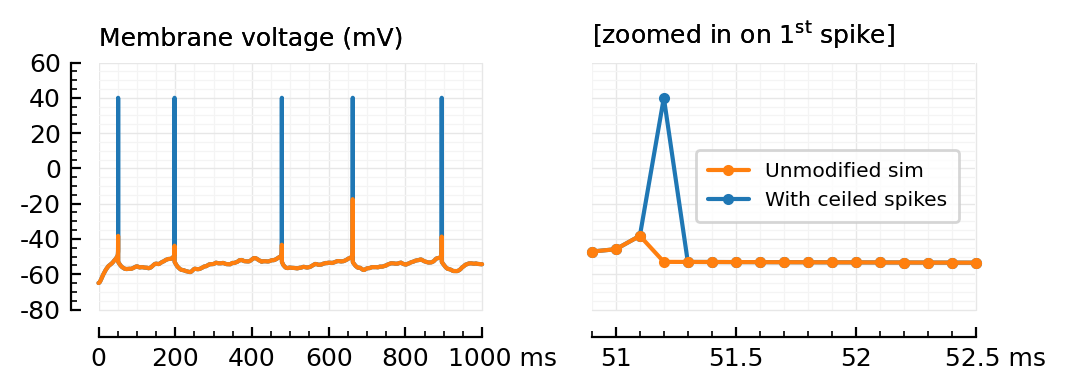

In [38]:
function ceilplot(; tlim, marker=nothing, ax, kw...)
    xkw = (xlabel=nothing, xunit_in=:last_ticklabel, ylim=[-80, 60])
    plotsig(sim_ceil.V / mV, tlim, ms, label="With ceiled spikes"; ax, marker, xlim=tlim, xkw..., kw...);
    plotsig(sim.V / mV, tlim, ms, label="Unmodified sim"; ax, marker, xlim=tlim, xkw..., kw...);
end

fig, axs = plt.subplots(ncols=2, figsize=(1.2*mtw, 0.45*mtw))
ceilplot(tlim = [0, 1000], ax=axs[0], hylabel="Membrane voltage (mV)");
ceilplot(tlim = [50.9, 52.5], marker=".", ax=axs[1], hylabel=L"[zoomed in on $1^{\mathrm{st}}$ spike]",
         xticklocs=[51, 51.5, 52, 52.5]);
# deemph_middle_ticks(axs[0])
# t = mpl.ticker
# axis = axs[1].xaxis
# axis.set_minor_locator(t.MultipleLocator(0.1))
legend(axs[1], reverse=true, fontsize=7.3, loc="center right")
rm_ticks_and_spine(axs[1], "left")
plt.tight_layout();

- [x] Put legend in right axes? (move spike left, eg)
- [x] Call it 'Unmodified sim'?

In [39]:
savefig_phd("ceil_spikes", fig)

Saved at `../thesis/figs/ceil_spikes.pdf`

In [41]:
t = sim.spiketimes[1]
t / ms

51.2

In [42]:
(; Δt, Eₑ, Eᵢ, Δₜ, Vₜ, gₗ, Eₗ, C) = Nto1AdEx

i = round(Int, t/Δt)  # The spiketime `t` is one sample after where we want, but this i is correct

512

In [44]:
n = sim.rec[i]

(; V, gₑ, gᵢ, w) = n
V / mV

-38.2

In [45]:
Iₛ = gₑ*(V - Eₑ) + gᵢ*(V - Eᵢ)
DₜV  = (-gₗ*(V - Eₗ) + gₗ*Δₜ*exp((V-Vₜ)/Δₜ) - Iₛ - w) / C

V_new = V + Δt * DₜV
V_new / mV

9.66E+04

In [46]:
V_new / volt

96.6

In [47]:
DₜV

9.67E+05

In [48]:
n.DₜV

75.6

So yeah, why the discrep here.

"Ah, it's cause the n.V is what we get _after_ calculating n.DₜV, in simcode. Whereas here, we re-used that V. We'd get same result if we do our calc here with (V,w,g) values of prev i"

In [50]:
n = sim.rec[i-1]

(; V, gₑ, gᵢ, w) = n
V / mV

-45.8

In [51]:
Iₛ = gₑ*(V - Eₑ) + gᵢ*(V - Eᵢ)
DₜV  = (-gₗ*(V - Eₗ) + gₗ*Δₜ*exp((V-Vₜ)/Δₜ) - Iₛ - w) / C

V_new = V + Δt * DₜV
V_new / mV

-38.2

Yeah, okay. :)

("Exp grows fast!")